In [ ]:
#import modules
import math
import random
import numpy as np
from numpy.random import randint
from numpy import exp, pi
from numpy import linalg as LA
from numpy.fft import fft2, ifft2, fftshift
from matplotlib import pyplot as plt
from matplotlib.pyplot import rc
rc('text', usetex=True)
import cv2
from PIL import Image
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import copy

#import files
import sys
sys.path.append('..')
from utils import Likelihood
from utils import message_passing as mp
from utils import PtychoEP
from utils import ptycho_legacy
from utils import test
from utils import config
from utils import engines_legacy
from utils import error
from utils import matrix as mt

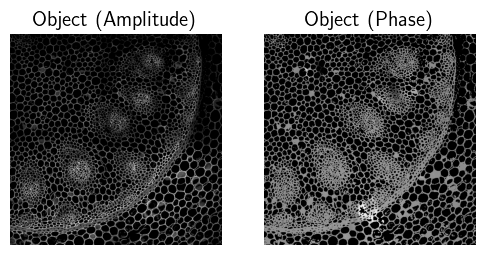

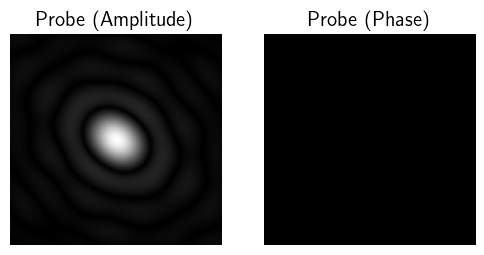

In [28]:
#load pbject image
path_obj_abs = "../data/lily.png"
path_obj_phase = "../data/moon.png"
obj = test.load_complex_image(path_obj_abs, path_obj_phase)

#load probe
probe_abs = np.array(Image.open("../data/probe.png"), dtype = "float")/256
prb = probe_abs + 1j * np.zeros_like(probe_abs)

#showimages
test.show_complex_image(obj, "Object")
test.show_complex_image(prb, "Probe")

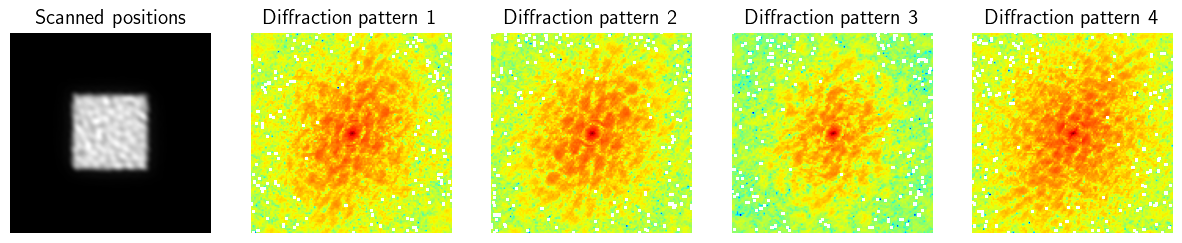

SNR =  29.963203964947304
Samping ratio =  172.06067677946325
Number of scans =  441


In [ ]:
np.random.seed(2)
#set scan position and noise variance
#noise = 0.00196 # cameraman 30dB
noise = 0.001039
scan_positions = []

c = 8
for i in range(21):
    for j in range(21):
        scan_positions.append([165 + c * i + np.random.randint(-2,2), 165 + c * j + np.random.randint(-2,2)])

#sorting
scan_positions = np.array(scan_positions)
distance = []
for i, scan_pos in enumerate(scan_positions):
    distance.append((255 - scan_pos[0])**2 + (255 - scan_pos[1])**2)
distance = np.array(distance)
scan_positions = scan_positions[np.argsort(distance)]

#create Ptycho object 
ptycho_data = ptycho.Ptycho(obj, prb, scan_positions, noise)
ptycho_data.show()

#initial guess of probe
probe_guess_abs = np.array(Image.open("../data/probe_init.png"), dtype = "float")/256
prb_guess = probe_guess_abs + 1j * np.zeros_like(probe_guess_abs)

#show SNR, sampling ratio, and number of scans
total = 0
for diff in ptycho_data.diffs:
    total += np.mean(diff**2)
total /= len(scan_positions)
print("SNR = ",10 * np.log10(total/noise**2))
print("Samping ratio = ", ptycho_data.sampling_ratio)
print("Number of scans = ", len(ptycho_data.scan_pos))

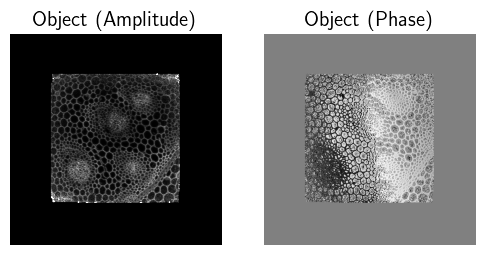

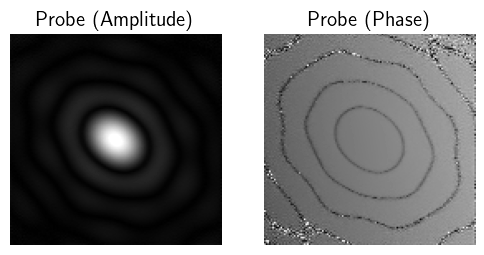

In [30]:
obj_init = mt.complex_gaussian_matrix(512, 1)
prb_init = copy.deepcopy(prb_guess)

#make config

num_iter = 100 #maximum iteration number
config_DM = config.config_DM(obj_init, prb_init, num_iter)

#run DM
obj_DM, prb_DM, error_DM = engines.DifferenceMap(ptycho_data, config_DM)

#show DM reconstruction
test.show_complex_image(obj_DM, "Object")
test.show_complex_image(prb_DM, "Probe")

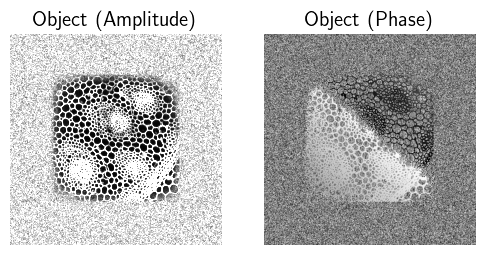

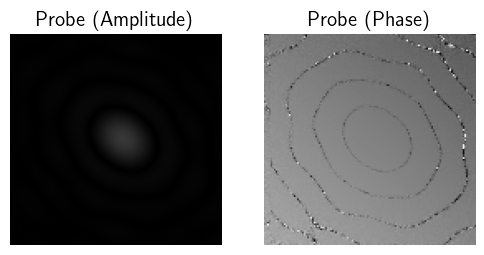

In [31]:
#load initial guess of probe
obj_init = mt.complex_gaussian_matrix(512, 1)
prb_init = copy.deepcopy(prb_guess)

#make config
alpha, beta = 1.0, 1.0 #step size parameters in ePIE
num_iter = 200 #maximum iteration number

#run ePIE
config_ePIE = config.config_ePIE(alpha, beta, obj_init, prb_init, num_iter)
obj_ePIE, prb_ePIE, error_ePIE = engines.ePIE(ptycho_data, config_ePIE)

#show ePIE reconstruction
test.show_complex_image(obj_ePIE, "Object")
test.show_complex_image(prb_ePIE, "Probe")

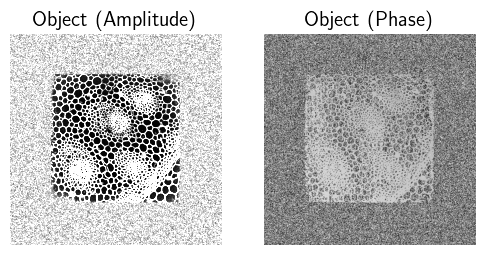

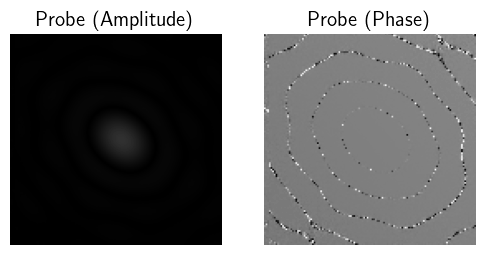

In [32]:
#load initial guess of probe
obj_init = mt.complex_gaussian_matrix(512, 1)
prb_init = copy.deepcopy(prb_guess)

#make config
alpha, beta = 0.1, 1.0 #step size parameters in rPIE
num_iter = 200 #maximum iteration number

#run ePIE
config_rPIE = config.config_ePIE(alpha, beta, obj_init, prb_init, num_iter)
obj_rPIE, prb_rPIE, error_rPIE = engines.rPIE(ptycho_data, config_rPIE)

#show ePIE reconstruction
test.show_complex_image(obj_rPIE, "Object")
test.show_complex_image(prb_rPIE, "Probe")

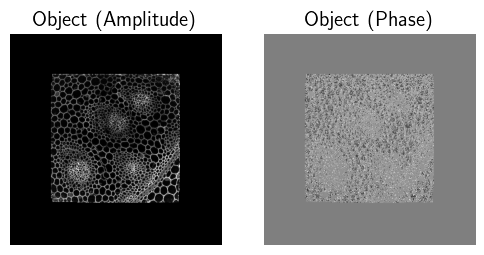

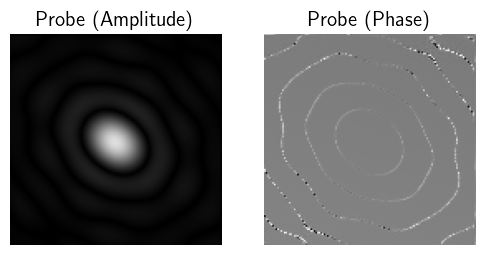

In [33]:
#load initial guess of probe
obj_init = mt.complex_gaussian_matrix(512, 1)
prb_init = copy.deepcopy(prb_guess)

#make config
num_iter = 100
num_prb = 2
damping = 0.9
config_PtychoEP_EM = config.config_PtychoEP(obj_init, prb_init, num_iter, num_prb, damping)

#run VAMP
obj_PtychoEP_EM, gamma_PtychoEP_EM, prb_PtychoEP_EM, error_PtychoEP_EM = PtychoEP.PtychoEP_Gaussian_EM(ptycho_data, config_PtychoEP_EM)

#show results
test.show_complex_image(obj_PtychoEP_EM, "Object")
test.show_complex_image(prb_PtychoEP_EM, "Probe")

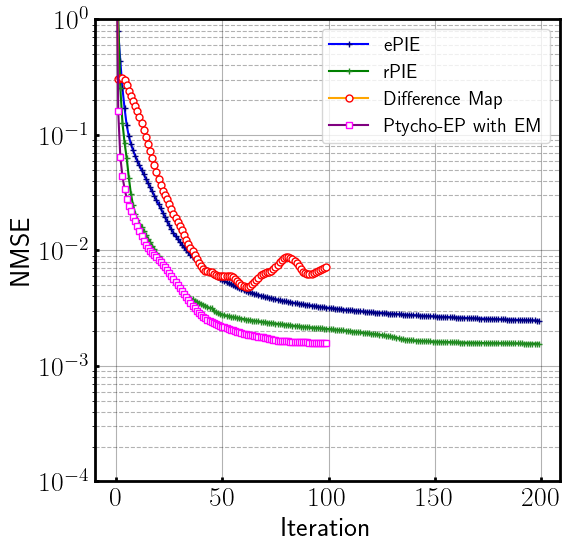

In [34]:
#show result
fig, ax = plt.subplots(1,1, figsize=(6, 6))
plt.tick_params(direction="in", length=3, width=2, labelsize=20)
ax.spines["right"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)
ax.plot(error_ePIE/total, color = "blue", marker = "+", markeredgecolor = "navy", markerfacecolor = "white", markersize = 5, label = "ePIE")
ax.plot(error_rPIE/total, color = "green", marker = "+", markeredgecolor = "forestgreen", markerfacecolor = "white", markersize = 5, label = "rPIE")
ax.plot(error_DM/total, color = "orange", marker = "o", markeredgecolor = "red", markerfacecolor = "white", markersize = 5, label = "Difference Map")
ax.plot(error_PtychoEP_EM/total, color = "purple", marker = "s", markeredgecolor = "magenta", markerfacecolor = "white", markersize = 5, label = "Ptycho-EP with EM")
ax.set_xlabel("Iteration", fontsize = 20)
ax.set_ylabel("NMSE", fontsize = 20)
ax.set_ylim(1e-4, 1)
ax.set_yscale('log')
ax.legend(fontsize = 14)
ax.grid(which='major',color='black',linestyle='-', alpha = 0.3)
ax.grid(which='minor',color='black',linestyle='--', alpha = 0.3)

(-0.5, 254.5, 254.5, -0.5)

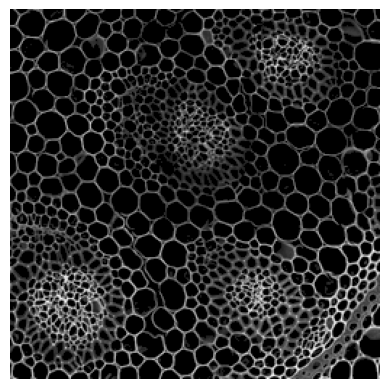

In [35]:
plt.imshow(np.abs(obj[128: 383, 128: 383]), cmap = "gray")
plt.axis("off")

(-0.5, 62.5, 62.5, -0.5)

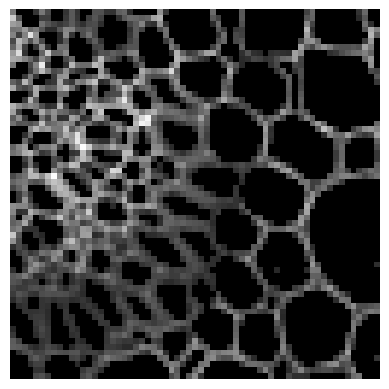

In [36]:
plt.imshow(np.abs(obj[192: 255, 255: 318]), cmap = "gray")
plt.axis("off")

(-0.5, 254.5, 254.5, -0.5)

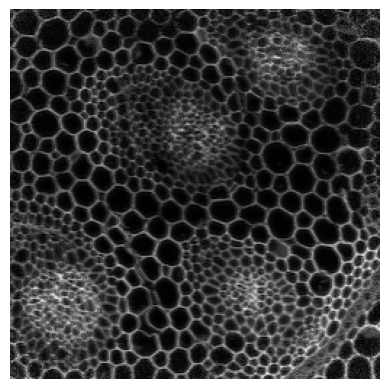

In [37]:
plt.imshow(np.abs(obj_DM[129: 384, 131: 386]), cmap = "gray")
plt.axis("off")

(-0.5, 62.5, 62.5, -0.5)

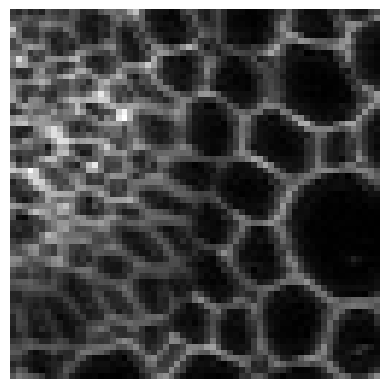

In [38]:
plt.imshow(np.abs(obj_DM[193: 256, 258: 321]), cmap = "gray")
plt.axis("off")

(-0.5, 254.5, 254.5, -0.5)

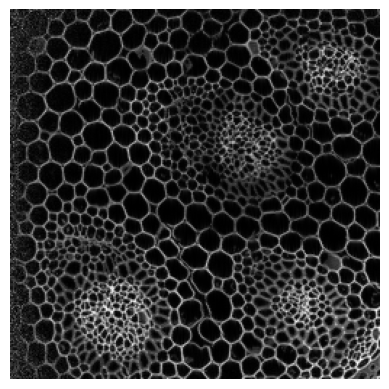

In [39]:
plt.imshow(np.abs(obj_ePIE[120: 375, 100: 355]), cmap = "gray")
plt.axis("off")

(-0.5, 62.5, 62.5, -0.5)

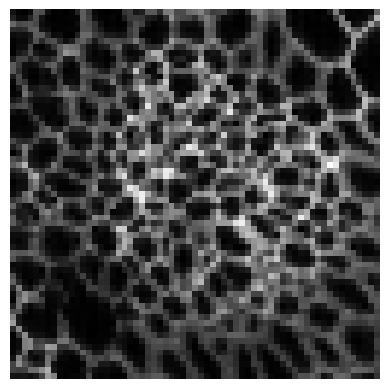

In [40]:
plt.imshow(np.abs(obj_ePIE[184: 247, 227: 290]), cmap = "gray")
plt.axis("off")

(-0.5, 254.5, 254.5, -0.5)

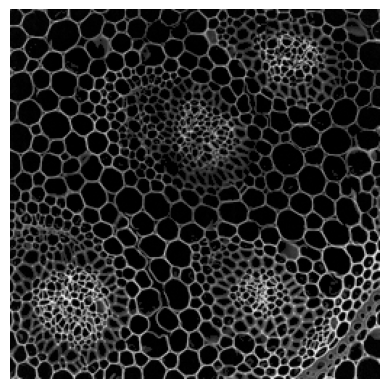

In [41]:
plt.imshow(np.abs(obj_rPIE[128: 383, 128: 383]), cmap = "gray")
plt.axis("off")

(-0.5, 62.5, 62.5, -0.5)

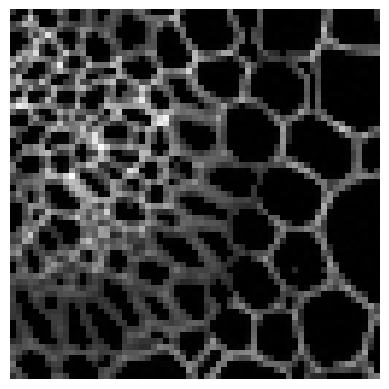

In [42]:
plt.imshow(np.abs(obj_rPIE[192: 255, 255: 318]), cmap = "gray")
plt.axis("off")

(-0.5, 254.5, 254.5, -0.5)

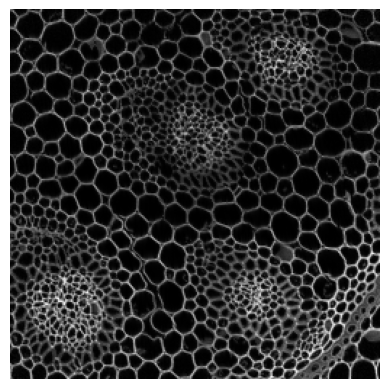

In [43]:
plt.imshow(np.abs(obj_PtychoEP_EM[128: 383, 128: 383]), cmap = "gray")
plt.axis("off")

(-0.5, 62.5, 62.5, -0.5)

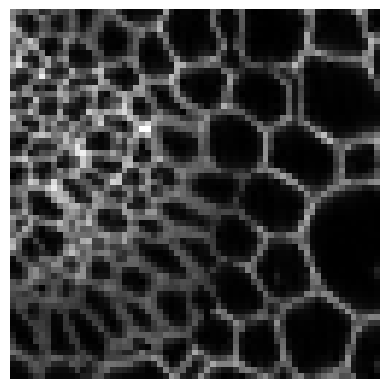

In [44]:
plt.imshow(np.abs(obj_PtychoEP_EM[192: 255, 254: 317]), cmap = "gray")
plt.axis("off")

### Median

In [45]:
#config
num_iter = 100 #maximum iteration number
num_mc = 10
result = np.zeros((num_mc, num_iter))
for i in range(num_mc):
    #set scan
    scan_positions = []
    c = 18
    for x in range(11):
        for y in range(11):
            scan_positions.append([165 + c * x + np.random.randint(-2,2), 165 + c * y + np.random.randint(-2,2)])
    scan_positions = np.array(scan_positions)
    distance = []
    for scan_pos in scan_positions:
        distance.append((255 - scan_pos[0])**2 + (255 - scan_pos[1])**2)
    distance = np.array(distance)
    scan_positions = scan_positions[np.argsort(distance)]
    #create Ptycho object 
    ptycho_data = ptycho.Ptycho(obj, prb, scan_positions, noise)
    #normalize
    total = 0
    for diff in ptycho_data.diffs:
        total += np.mean(diff**2)
    total /= len(scan_positions)
    #initialize DM
    obj_init = mt.complex_gaussian_matrix(512, 1)
    prb_init = copy.deepcopy(prb_guess)
    config_DM = config.config_DM(obj_init, prb_init, num_iter)
    #run DM
    _,_, error = engines.DifferenceMap(ptycho_data, config_DM)
    result[i] = copy.deepcopy(error/total)
DM_error_median = np.median(result, axis = 0)
plt.plot(DM_error_median)
plt.yscale("log")

KeyboardInterrupt: 

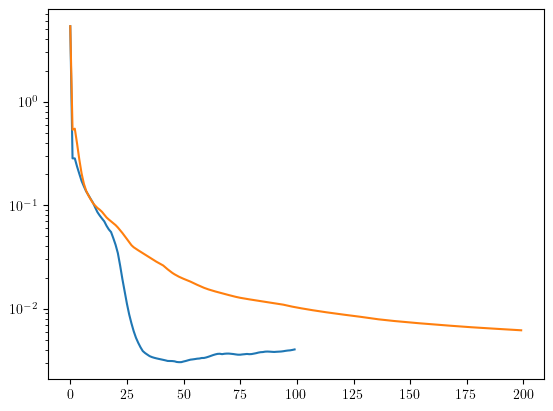

In [ ]:
#config
num_iter = 200 #maximum iteration number
num_mc = 10
alpha, beta = 1.0, 1.0 #step size parameters in ePIE
result = np.zeros((num_mc, num_iter))
for i in range(num_mc):
    #set scan
    scan_positions = []
    c = 18
    for x in range(11):
        for y in range(11):
            scan_positions.append([165 + c * x + np.random.randint(-2,2), 165 + c * y + np.random.randint(-2,2)])
    scan_positions = np.array(scan_positions)
    distance = []
    for scan_pos in scan_positions:
        distance.append((255 - scan_pos[0])**2 + (255 - scan_pos[1])**2)
    distance = np.array(distance)
    scan_positions = scan_positions[np.argsort(distance)]
    #create Ptycho object 
    ptycho_data = ptycho.Ptycho(obj, prb, scan_positions, noise)
    #normalize
    total = 0
    for diff in ptycho_data.diffs:
        total += np.mean(diff**2)
    total /= len(scan_positions)
    #initialize ePIE
    obj_init = mt.complex_gaussian_matrix(512, 1)
    prb_init = copy.deepcopy(prb_guess)
    config_ePIE = config.config_ePIE(alpha, beta, obj_init, prb_init, num_iter)
    #run ePIE
    _, _ , error= engines.ePIE(ptycho_data, config_ePIE)
    result[i] = copy.deepcopy(error/total)
ePIE_error_median = np.median(result, axis = 0)
plt.plot(DM_error_median)
plt.plot(ePIE_error_median)
plt.yscale("log")

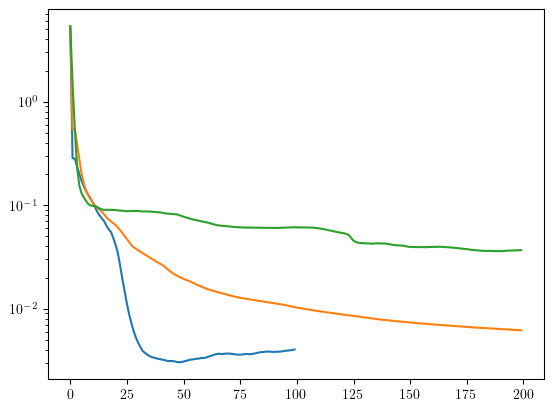

In [ ]:
#config
num_iter = 200 #maximum iteration number
num_mc = 10
alpha, beta = 0.1, 1.0 #step size parameters in ePIE
result = np.zeros((num_mc, num_iter))
for i in range(num_mc):
    #set scan
    scan_positions = []
    c = 18
    for x in range(11):
        for y in range(11):
            scan_positions.append([165 + c * x + np.random.randint(-2,2), 165 + c * y + np.random.randint(-2,2)])
    scan_positions = np.array(scan_positions)
    distance = []
    for scan_pos in scan_positions:
        distance.append((255 - scan_pos[0])**2 + (255 - scan_pos[1])**2)
    distance = np.array(distance)
    scan_positions = scan_positions[np.argsort(distance)]
    #create Ptycho object 
    ptycho_data = ptycho.Ptycho(obj, prb, scan_positions, noise)
    #normalize
    total = 0
    for diff in ptycho_data.diffs:
        total += np.mean(diff**2)
    total /= len(scan_positions)
    #initialize ePIE
    obj_init = mt.complex_gaussian_matrix(512, 1)
    prb_init = copy.deepcopy(prb_guess)
    config_rPIE = config.config_ePIE(alpha, beta, obj_init, prb_init, num_iter)
    #run rPIE
    _, _ , error = engines.rPIE(ptycho_data, config_rPIE)
    result[i] = copy.deepcopy(error/total)
rPIE_error_median = np.median(result, axis = 0)
plt.plot(DM_error_median)
plt.plot(ePIE_error_median)
plt.plot(rPIE_error_median)
plt.yscale("log")

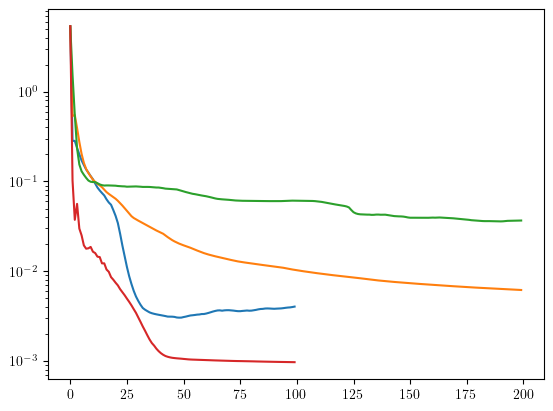

In [ ]:
#config
num_iter = 100 #maximum iteration number
num_mc = 10
damping = 0.9
result = np.zeros((num_mc, num_iter))
for i in range(num_mc):
    #set scan
    scan_positions = []
    c = 18
    for x in range(11):
        for y in range(11):
            scan_positions.append([165 + c * x + np.random.randint(-2,2), 165 + c * y + np.random.randint(-2,2)])
    scan_positions = np.array(scan_positions)
    distance = []
    for scan_pos in scan_positions:
        distance.append((255 - scan_pos[0])**2 + (255 - scan_pos[1])**2)
    distance = np.array(distance)
    scan_positions = scan_positions[np.argsort(distance)]
    #create Ptycho object 
    ptycho_data = ptycho.Ptycho(obj, prb, scan_positions, noise)
    #normalize
    total = 0
    for diff in ptycho_data.diffs:
        total += np.mean(diff**2)
    total /= len(scan_positions)
    #initialize ePIE
    obj_init = mt.complex_gaussian_matrix(512, 1)
    prb_init = copy.deepcopy(prb_guess)
    config_PtychoEP_EM = config.config_PtychoEP(obj_init, prb_init, num_iter, num_prb, damping)
    #run DM
    _, _ , _, error = PtychoEP.PtychoEP_Gaussian_EM(ptycho_data, config_PtychoEP_EM)
    result[i] = copy.deepcopy(error/total)
PtychoEP_error_median = np.median(result, axis = 0)
plt.plot(DM_error_median)
plt.plot(ePIE_error_median)
plt.plot(rPIE_error_median)
plt.plot(PtychoEP_error_median)
plt.yscale("log")

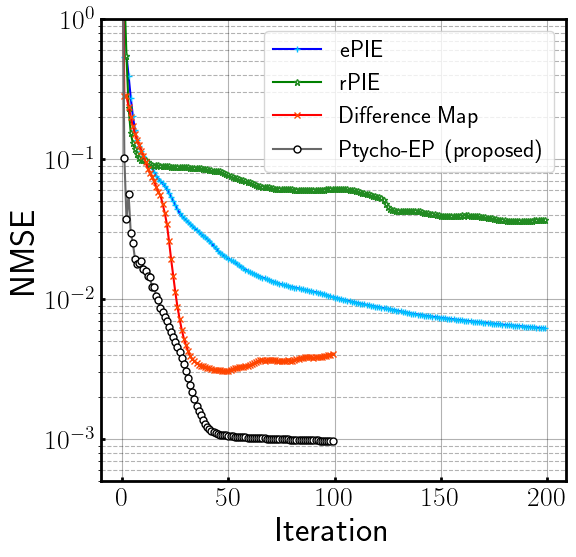

In [ ]:
#show result
fig, ax = plt.subplots(1,1, figsize=(6, 6))
plt.tick_params(direction="in", length=3, width=2, labelsize=20)
ax.spines["right"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)
ax.plot(ePIE_error_median, color = "blue", marker = "+", markeredgecolor = "deepskyblue", markerfacecolor = "white", markersize = 5, label = "ePIE")
ax.plot(rPIE_error_median, color = "green", marker = "*", markeredgecolor = "forestgreen", markerfacecolor = "white", markersize = 5, label = "rPIE")
ax.plot(DM_error_median, color = "red", marker = "x", markeredgecolor = "orangered", markerfacecolor = "white", markersize = 5, label = "Difference Map")
ax.plot(PtychoEP_error_median, color = "dimgray", marker = "o", markeredgecolor = "black", markerfacecolor = "white", markersize = 5, label = "Ptycho-EP (proposed)")
ax.set_xlabel("Iteration", fontsize = 25)
ax.set_ylabel("NMSE", fontsize = 25)
ax.set_ylim(5e-4, 1)
ax.set_yscale('log')
ax.legend(fontsize = 17)
ax.grid(which='major',color='black',linestyle='-', alpha = 0.3)
ax.grid(which='minor',color='black',linestyle='--', alpha = 0.3)